# Indian food detection using Detectron2

In this tutorial we will see how to do detection on images using detectron2. I have downloaded couple of images from google search and annotated it using [labelme](https://github.com/wkentaro/labelme).

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


As I haved used the labelme annotation tool the dataset is not in coco format.

In [4]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode
from detectron2.data import MetadataCatalog, DatasetCatalog
import os
import json

label2id_map = {'roti':1, 'sabji':3, 'dal':2, 'chawal': 4}

def get_balloon_dicts(datasetdir):
    
    img_dir = datasetdir +'/image/'
    json_dir = datasetdir +'/json/'
    
    
    dataset_dicts = []
    filename = ''
    idx=0
    print
    for files in os.listdir(json_dir):
        #print(files)
        #get the filename by spliting name.json
        name = files.split('.')[0]
        
        #json directory
        json_file= os.path.join(json_dir, files)
        filename = img_dir+name+'.jpeg'
        
        #print(filename)
        #check if that image exists
        if os.path.exists(filename):
            
            height, width = cv2.imread(filename).shape[:2]
            
            data= json.load(open(json_file))
            record = {}
            record["file_name"] = filename
            record["image_id"] = idx
            record["height"] = height
            record["width"] = width
            objs=[]
            for shape in data['shapes']:
                label = shape['label']
                if label == 'roti' or label == 'sabji' or label =='dal' or label =='chawal' :
                    pts = np.asarray(shape["points"])
                    
                    
                    px = pts[:,0]
                    py = pts[:,1]
                   
                    poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
                    poly = [p for x in poly for p in x]
                    
                    obj = {
                        "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "segmentation": [poly],
                        "category_id": label2id_map[label]-1,
                            }
                    
                    objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
       # break
    return dataset_dicts


img_dir = './indianfood/image/'
json_dir = './indianfood/json/'

dataset_dir = './indianfood/'
for d in ["train", "val"]:
    DatasetCatalog.register("indianfood_"+d, lambda d=d: get_balloon_dicts(dataset_dir+d))
    MetadataCatalog.get("indianfood_"+d).set(thing_classes=["roti", "sabji", "dal", "chawal"])

indianfood_metadata = MetadataCatalog.get("indianfood_train")

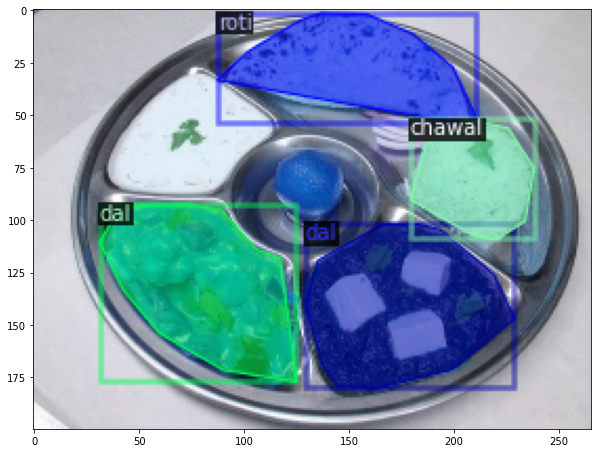

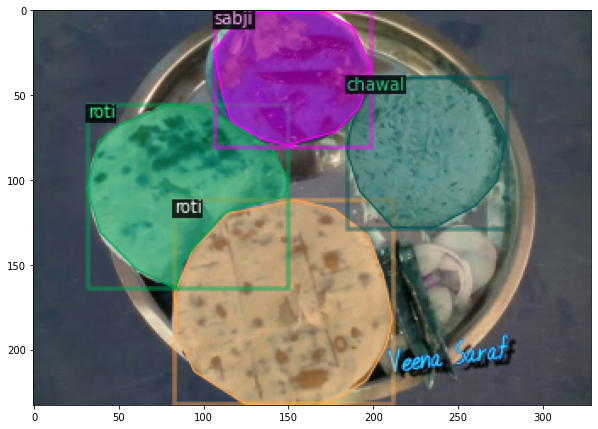

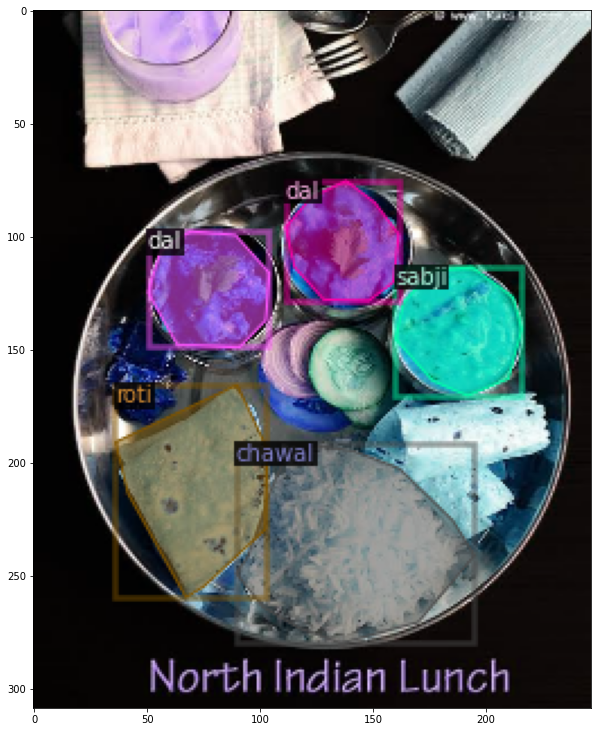

In [5]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json

dataset_dicts = get_balloon_dicts(dataset_dir+'train')
#print(dataset_dicts)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=indianfood_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(10,25))
    plt.imshow(out.get_image()[:, :, ::-1])

In [6]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("indianfood_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 1000 iterations for this dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[10/02 07:19:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (4, 256, 1, 1) 

[10/02 07:19:51 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.6/dist-packages/detectron2/structures/masks.py:331: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/usr/local/lib/python3.6/dist-packages/detectron2/structures/masks.py:331: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/usr/local/lib/python3.6/dist-packages/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_

[10/02 07:20:00 d2.utils.events]:  eta: 0:07:09  iter: 19  total_loss: 3.235  loss_cls: 1.579  loss_box_reg: 0.917  loss_mask: 0.690  loss_rpn_cls: 0.014  loss_rpn_loc: 0.021  time: 0.4282  data_time: 0.0197  lr: 0.000005  max_mem: 2551M
[10/02 07:20:08 d2.utils.events]:  eta: 0:06:55  iter: 39  total_loss: 3.116  loss_cls: 1.491  loss_box_reg: 0.908  loss_mask: 0.686  loss_rpn_cls: 0.017  loss_rpn_loc: 0.020  time: 0.4322  data_time: 0.0105  lr: 0.000010  max_mem: 2762M
[10/02 07:20:17 d2.utils.events]:  eta: 0:06:48  iter: 59  total_loss: 2.944  loss_cls: 1.322  loss_box_reg: 0.935  loss_mask: 0.676  loss_rpn_cls: 0.014  loss_rpn_loc: 0.016  time: 0.4318  data_time: 0.0075  lr: 0.000015  max_mem: 2762M
[10/02 07:20:26 d2.utils.events]:  eta: 0:06:39  iter: 79  total_loss: 2.712  loss_cls: 1.111  loss_box_reg: 0.922  loss_mask: 0.660  loss_rpn_cls: 0.014  loss_rpn_loc: 0.016  time: 0.4339  data_time: 0.0098  lr: 0.000020  max_mem: 2762M
[10/02 07:20:35 d2.utils.events]:  eta: 0:06:32 

In [7]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold for this model
cfg.DATASETS.TEST = ("indianfood_val", )
predictor = DefaultPredictor(cfg)

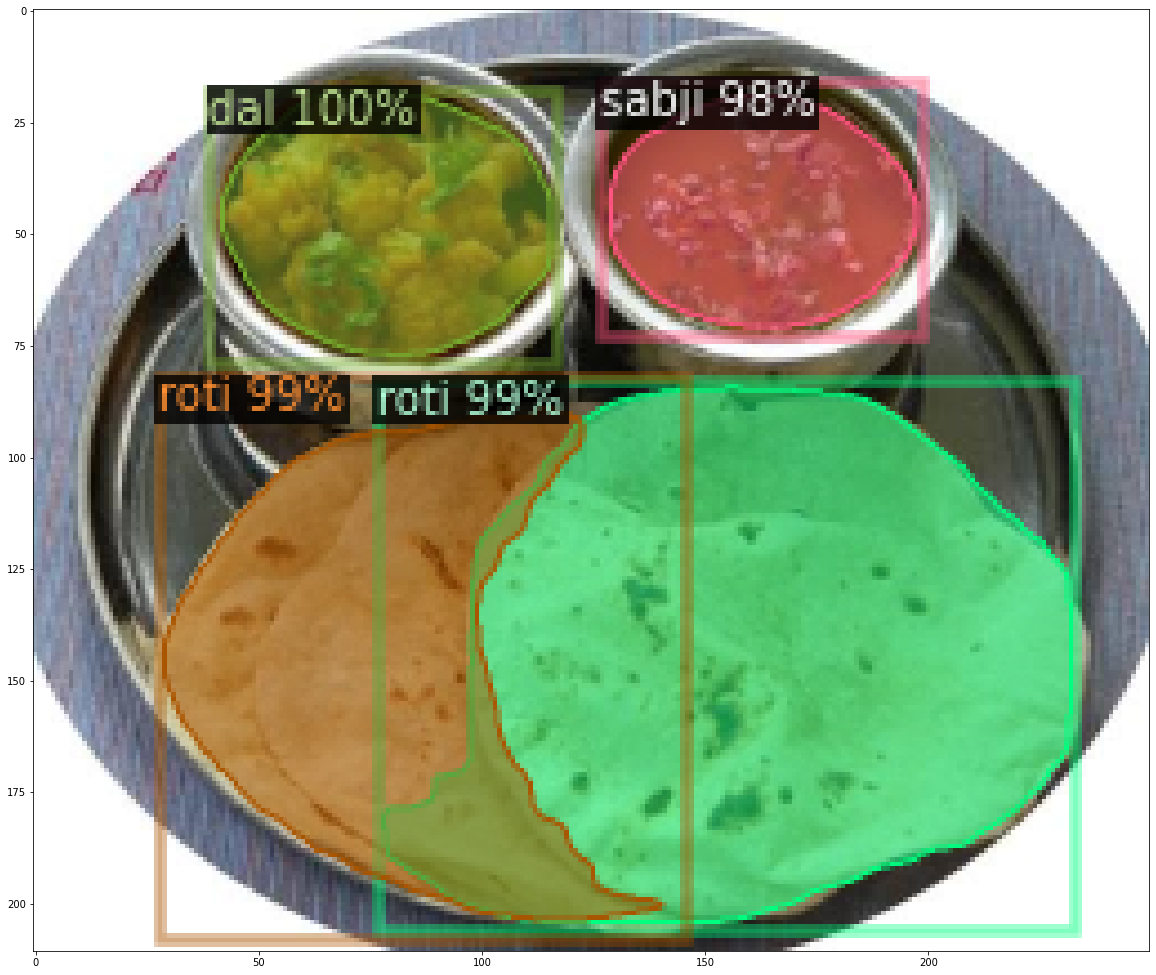

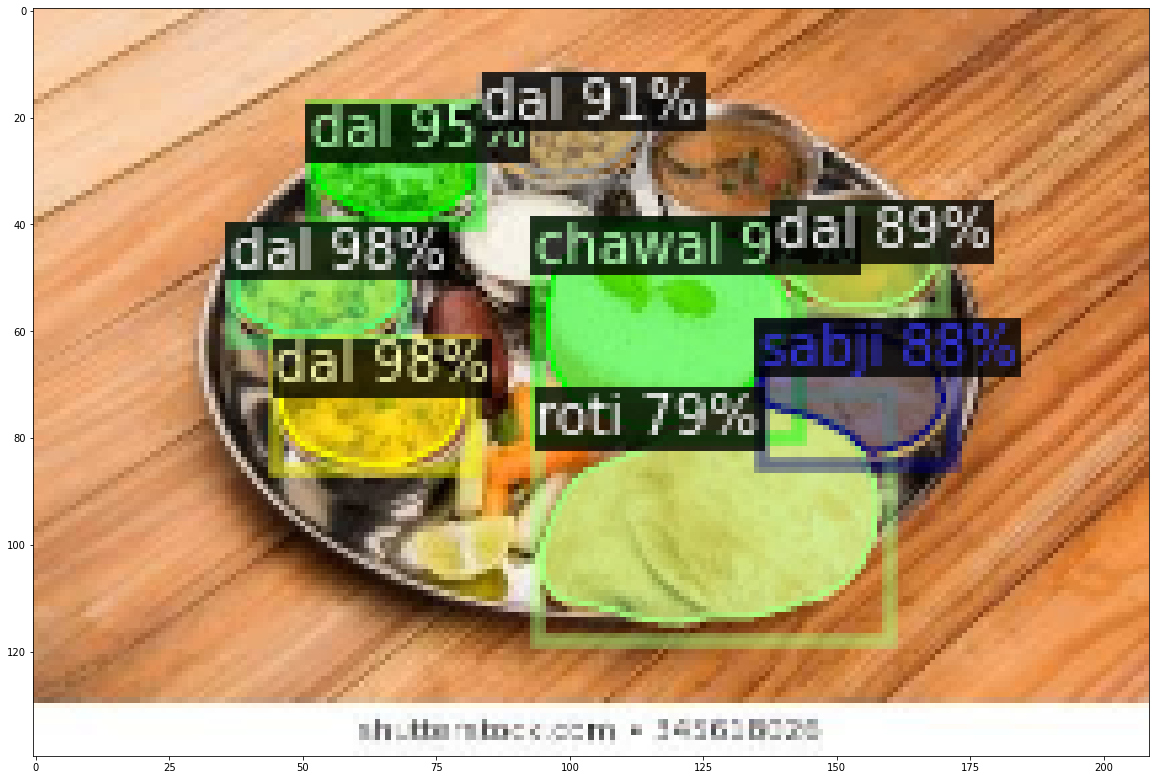

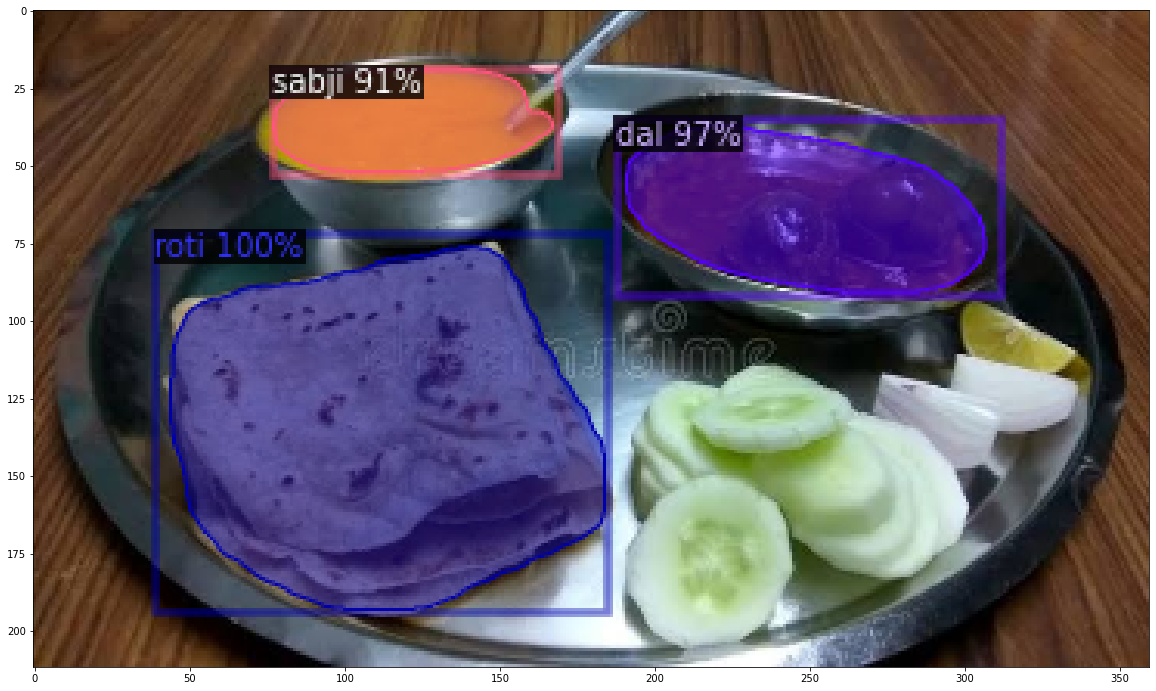

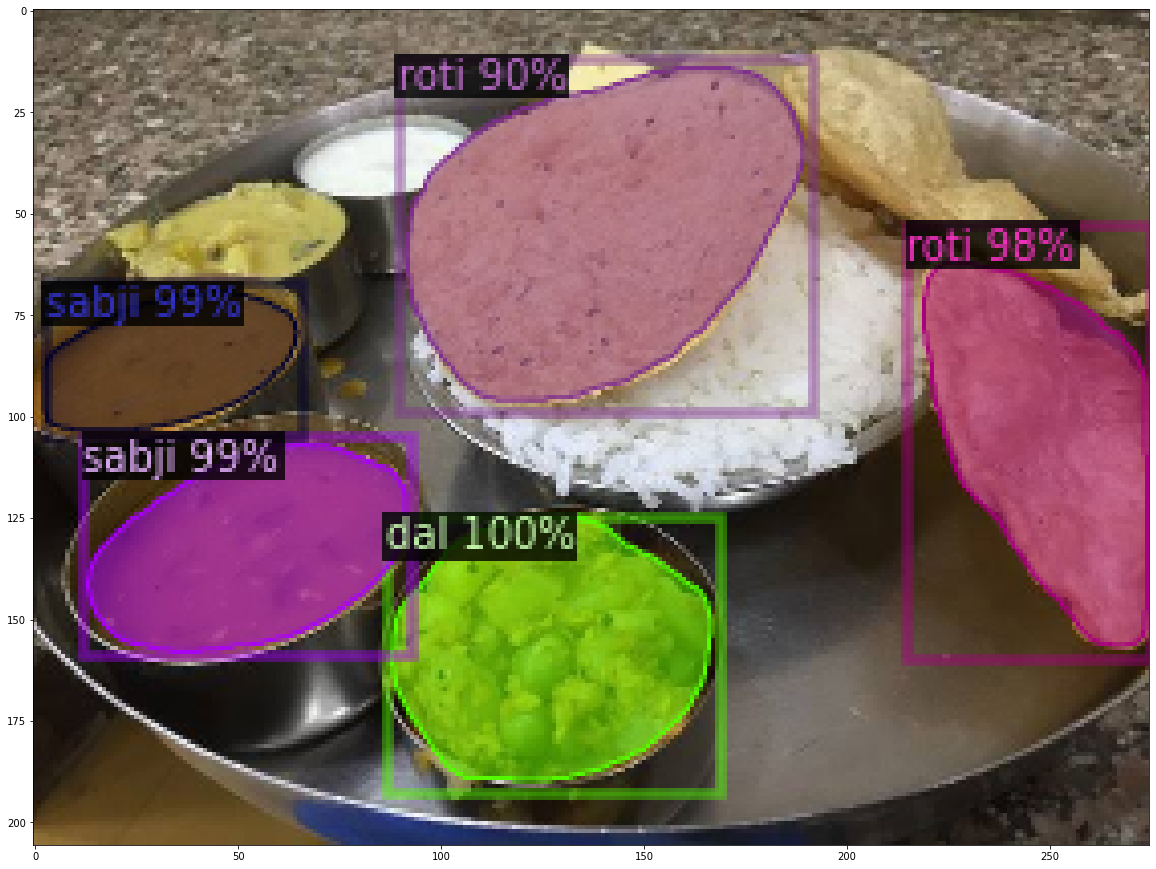

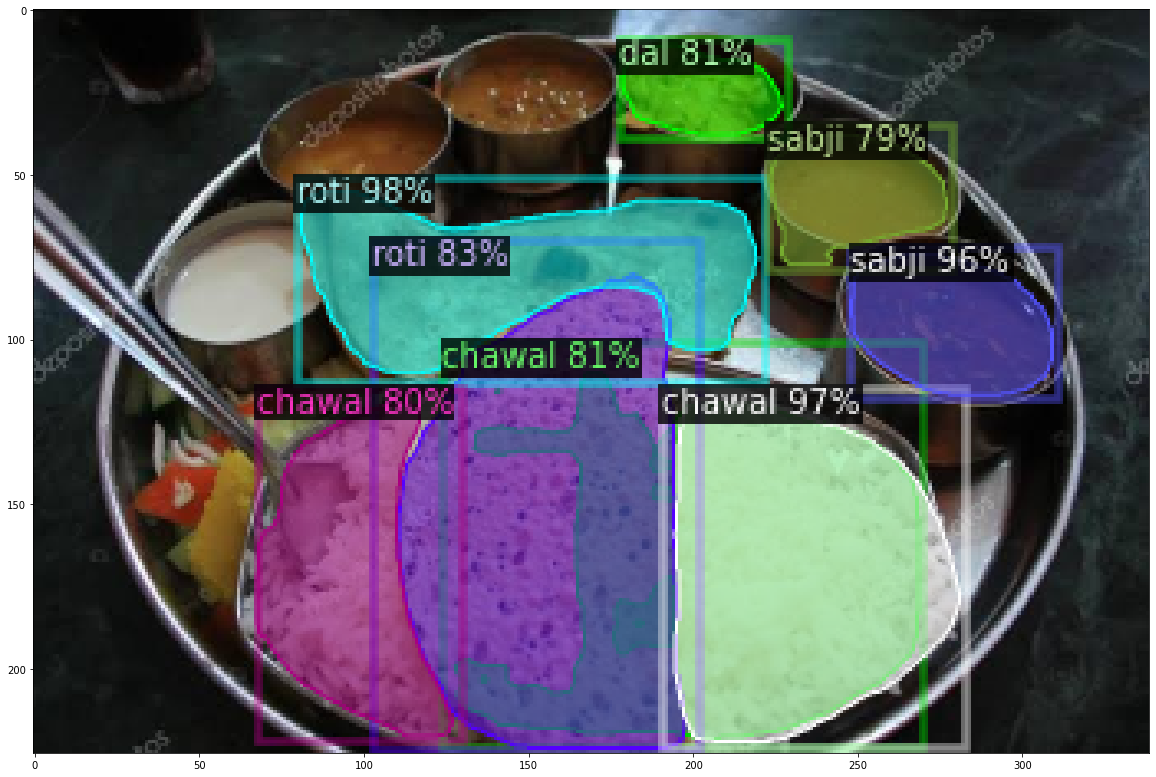

In [8]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts(dataset_dir+'val')
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=indianfood_metadata, 
                   scale=0.5
                   #, 
                  # instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    print(out)
   
    plt.figure(figsize =(20,40))
    plt.imshow(out.get_image()[:, :, :])

In [10]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("indianfood_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "indianfood_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

[10/02 07:27:48 d2.evaluation.coco_evaluation]: 'indianfood_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
WARNING [10/02 07:27:48 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/indianfood_val_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[10/02 07:27:49 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    roti    | 19           |   sabji    | 17           |    dal     | 35           |
|   chawal   | 9            |            |              |            |              |
|   total    | 80           |            |              |            |              |
[10/02 07:27:49 d2.data.common]: Serializing 23 elements to byte tensors and concatenating them all ...
[10/02 07: